#Sandbox
For playing around during development.

Todo:

- check that lookup table data is bound to the instance, not to the class

In [1]:
%pylab inline
import pysd
print pysd.__version__
print pysd.__file__

Populating the interactive namespace from numpy and matplotlib
0.3.1
pysd/__init__.pyc


In [2]:
model = pysd.read_vensim('tests/vensim/Teacup.mdl')

#model = pysd.read_xmile('tests/xmile/teacup.xmile')

In [ ]:
model.run()

In [4]:
import pandas as pd

In [ ]:
pd.read_excel()

In [ ]:
model.set_components({'room_temperature':pd.Series(np.linspace(20,80,30)})

In [11]:
result = model.run()
result.head()

,cuptemp
0.00,170.000000
0.25,165.755830
0.50,161.688256
0.75,157.789930
1.00,154.053813


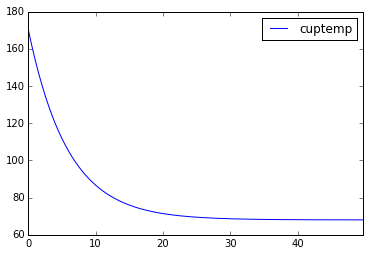

In [12]:
result.plot()

## PySD Performance
Lets plot the history of our speedup efforts:

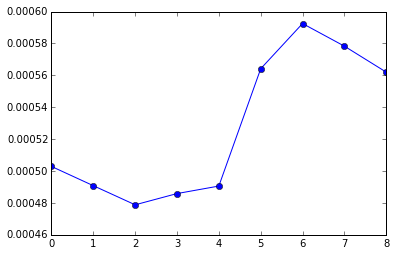

In [13]:
import pandas as pd

dictlist = []
with open('tests/speedtest_results.json') as infile:
    for line in infile:
        dictlist.append(eval(line))
    
speedtests = pd.DataFrame(dictlist)
speedtests['run teacup baseline'].plot(marker='o');